In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [2]:
df1 = pd.read_csv("C://Users//bhask//Downloads//Customers.csv")
df2 = pd.read_csv("C://Users//bhask//Downloads//Products.csv")
df3 = pd.read_csv("C://Users//bhask//Downloads//Transactions.csv")

In [3]:
data = pd.merge(df3,df1, on="CustomerID", how="inner")
data = pd.merge(data, df2, on="ProductID", how="inner")

In [4]:
customer_summary = data.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spending per customer
    "TransactionID": "count",  # Number of transactions per customer
    "ProductName": lambda x: x.mode()[0],  # Most purchased product
    "Category": lambda x: x.mode()[0],  # Most purchased category
}).reset_index()

In [5]:
customer_summary = customer_summary.merge(df1[["CustomerID", "Region"]], on="CustomerID", how="left")

In [6]:
# Handle categorical data Region and Category
customer_summary = pd.get_dummies(customer_summary, columns=["Region", "Category"])

In [7]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_summary.drop(columns=["CustomerID", "ProductName"]))

In [8]:
X = customer_summary.drop(columns=["CustomerID", "ProductName"])
X_scaled = scaler.fit_transform(X)

In [9]:
dbi_scores = []
for k in range(2, 11):  # Test for 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
    kmeans.fit(X_scaled)
    dbi = davies_bouldin_score(X_scaled, kmeans.labels_)
    dbi_scores.append(dbi)

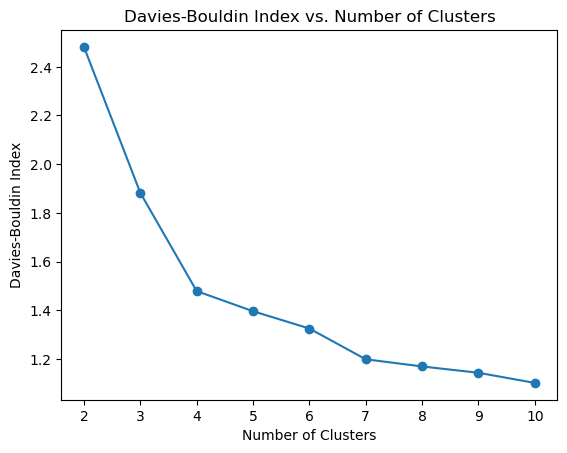

In [25]:
plt.plot(range(2, 11), dbi_scores, marker='o')
plt.title("Davies-Bouldin Index vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.show()

In [27]:
optimal_k = dbi_scores.index(min(dbi_scores)) + 2
print(f"Optimal Number of Clusters: {optimal_k}")
kmeans = KMeans(n_clusters=optimal_k, random_state=42,n_init=10)
customer_summary['Cluster'] = kmeans.fit_predict(X_scaled)

Optimal Number of Clusters: 10


In [29]:
dbi = davies_bouldin_score(X_scaled, customer_summary['Cluster'])
print(f"DB Index: {dbi:.2f}")

DB Index: 1.10


In [31]:
silhouette_avg = silhouette_score(X_scaled, customer_summary['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.36


<IPython.core.display.Javascript object>

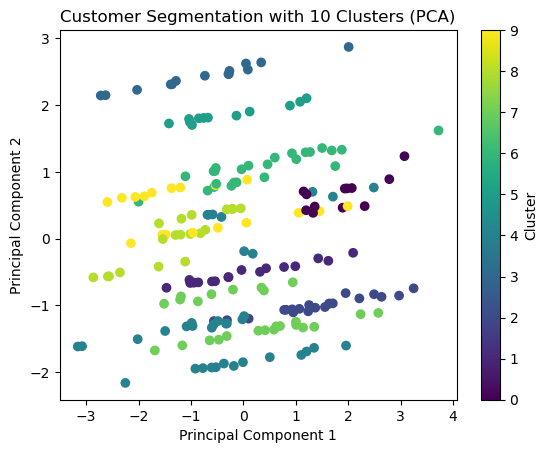

In [33]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=customer_summary['Cluster'], cmap='viridis')
plt.title(f"Customer Segmentation with {optimal_k} Clusters (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()